<a href="https://colab.research.google.com/github/MarkusThill/techdays25/blob/feature-lab1/notebooks/lab1-my-first-onnx-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚀 Lab 1: Erstelle dein erstes ONNX-Modell Schritt für Schritt
- Dieses Jupyter Notebook benötigt keine GPU Laufzeit. Falls nicht bereits voreingestellt, kann daher der Laufzeittyp im Menü unter "Laufzeit" > "Laufzeittyp ändern" > "Hardwarebeschleuniger" > "CPU" geändert werden!

# Vorbereitungen: Installation der nötigen Abhängigkeiten

In [ ]:
# Remove the `%%capture`, if you have the impression that something is going wrong during the setup
%%capture
!pip install "techdays25[lab1] @ git+https://github.com/MarkusThill/techdays25.git@main"

**WICHTIG: Nach der Installation der Abhängigkeiten (siehe oben) muss die Google Colab Laufzeit neugestartet werden! Im Anschluss kann mit der Ausführung der nächsten Zellen fortgefahren werden werden.**

In [1]:
# @title Some Colab-Specific Configuration {display-mode: "form"}
import sys

IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    from google.colab import output

    output.enable_custom_widget_manager()

# Einleitung

TODO

# Datengenerierung

In [2]:
# Import the data generation module and generate a small 2-dimensional dataset
from techdays25 import measurement_utils as mu

df = mu.generate_measurement_data()

print("df.shape:", df.shape)

# Show the first few lines of the DataFrame
df.head()

df.shape: (100, 2)


,voltage [V],current [mA]
0,4.494481,16.316118
1,11.408572,29.384164
2,8.783927,25.462657
3,7.183902,13.210136
4,1.872224,9.431659


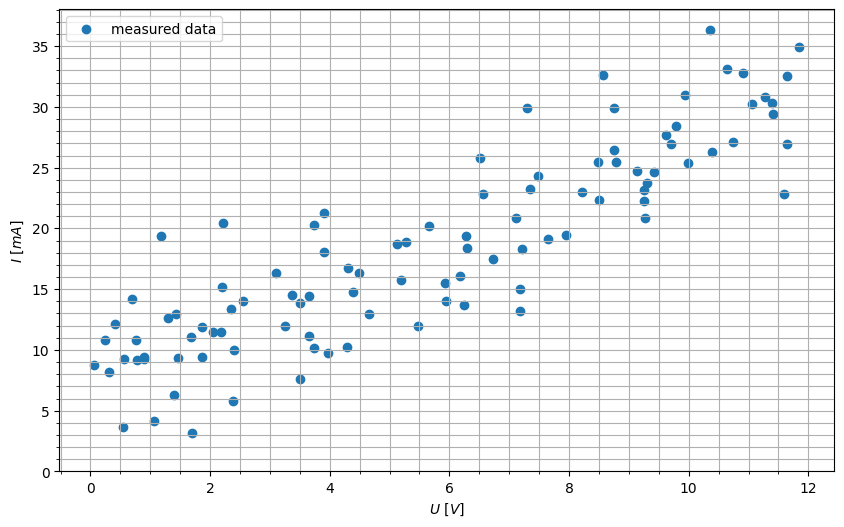

In [3]:
# @title Visualize the Generated Data {display-mode: "form"}
mu.plot_measurement_data(*df.to_numpy().T)

In [4]:
# TODO: Add Total Sum of Residuals

interactive(children=(FloatSlider(value=1.0, description='m', max=4.0, step=0.01), FloatSlider(value=1.0, desc…

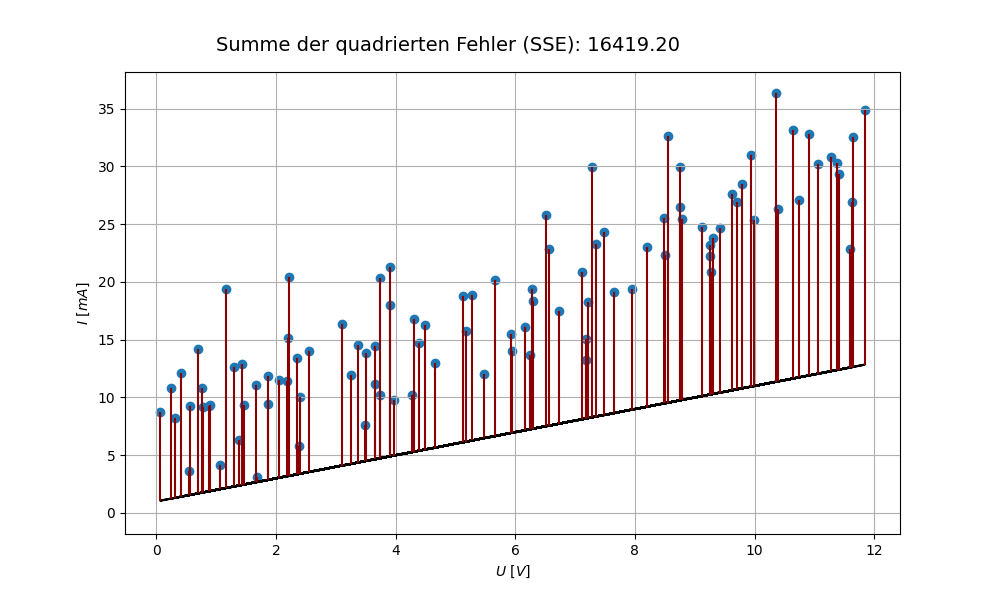

In [5]:
# @title Manually training a linear model {display-mode: "form"}

# This code will be hidden when the notebook is loaded.

%matplotlib widget
import ipywidgets as widgets
import matplotlib.pyplot as plt

# set up plot
fig, ax = plt.subplots(figsize=(10, 6))
fig.canvas.toolbar_visible = False
fig.canvas.resizable = False
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
fig.canvas.capture_scroll = True
ax.grid(True, which="both")

uu, ii = df.to_numpy().T

ax.scatter(uu, ii)

# plt.minorticks_on()
ax.set_xlabel(r"$U \ [V]$")
ax.set_ylabel(r"$I \ [mA]$")


def linear_func(x, m, b):
    """Return a ..."""
    return m * x + b


(line,) = ax.plot(uu, linear_func(uu, 0, 0), color="black")

dy = linear_func(uu, 0, 0) - ii
residuals_line = ax.vlines(uu, ii, ii + dy, color="darkred")

font = {
    "size": 14,
}
serr = sum(abs(dy) ** 2)
my_textbox = ax.text(
    1, 40, f"Summe der quadrierten Fehler (SSE): {serr: .2f}", fontdict=font
)


@widgets.interact(m=(0, 4, 0.01), b=(-10, 10, 0.01))
def update(m=1.0, b=1.0):
    """Remove old lines from plot and plot new one."""
    line.set_ydata(linear_func(uu, m, b))

    # Update line
    pred = linear_func(uu, m, b)
    dy = pred - ii
    seg = residuals_line.get_segments()
    new_seg = []
    for s, newMin, newMax in zip(seg, pred, pred - dy):
        s[0, -1] = newMin
        s[1, -1] = newMax
        new_seg.append(s)
    residuals_line.set_segments(new_seg)

    # Update text box
    serr = sum(abs(dy) ** 2)
    my_textbox.set_text(f"Summe der quadrierten Fehler (SSE): {serr:.2f}")

    fig.canvas.draw()

# Training unseres ersten Machine-Learning-Modells

## Variante 1: Lineare Regression mit SciKit-Learn und Export nach ONNX
TODO: Explain scikit-learn here:

- Das Scikit-Learn Modell versucht, die Steigung `m` und den Y-Achsenabschnitt (Ordinatenabschnitt) `b` so zu wählen, dass die Summe der quadratischen Fehler minimiert wird

Weitere Details und Beispiele können hier nachgeschlagen werden:
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [6]:
import numpy as np
from sklearn.linear_model import LinearRegression

# write the recorded voltages and currents into the two numpy arrays `u` and `i`
uu, ii = df.to_numpy().T

# Note that the input has to be reshaped to a matrix of shape (N, 1)
# since the LinearRegression model is designed to handle multivariate
# regression problems
U = uu.reshape(-1, 1)

# Initialize and train regressor
scikit_regressor = LinearRegression().fit(U, ii)

In [7]:
# Get the fitted slope `m` and the intercept `b`
scikit_regressor.coef_, scikit_regressor.intercept_

(array([1.96461942]), np.float64(7.2982815214755234))

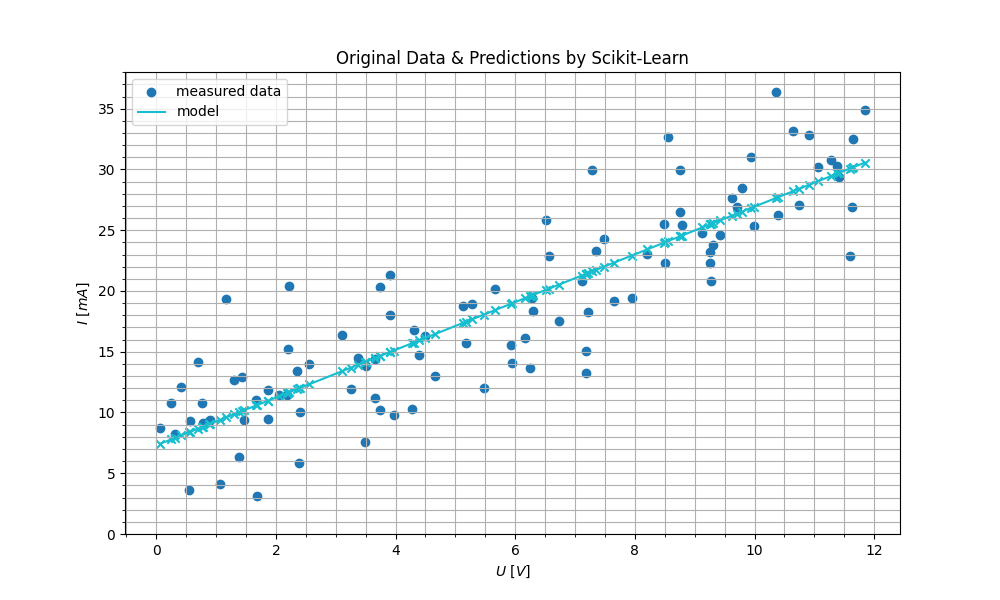

In [8]:
# Now let us put the original data through the model and plot the obtained predictions:

# put the Nx1-shaped input through the regression model
ii_scikit = scikit_regressor.predict(U)

# Plot the predicted line
mu.plot_measurement_data(
    uu,
    ii,
    ii_scikit,
    title="Original Data & Predictions by Scikit-Learn",
)

### Fragen/Zusatzaufgaben (Optional)
1. Stimmen die durch Scikit-Learn ermittelten Parameter `regressor.coef_, regressor.intercept_` in etwa mit den Werten `m` und `b` überein, die ihr im interaktivem Widget weiter oben ermittelt habt?
2. Könnt ihr die Summe der quadratischen Abweichungen (SSE) für das scikit-learn-Model bestimmen und vergleichen mit dem SSE den ihr manuell erzielt habt?
2. Wie könnten wir überprüfen, ob die ermittelten Parameter `m`, `b` schlüssig sind?
3. Könnt ihr für 5 neue beliebige Inputs ($U [V]$) auch die zugehörigen Ströme ($I [mA]$) prognostizieren und plotten?

### Export des scikit-learn Modells nach ONNX
TODO: Beschreibung

In [9]:
from pathlib import Path

import onnx
import skl2onnx
from skl2onnx.common.data_types import FloatTensorType

# Define the initial type for the model's input
initial_type = [("float_input", FloatTensorType([None, U.shape[1]]))]

# Convert the model
onnx_model = skl2onnx.convert_sklearn(scikit_regressor, initial_types=initial_type)

# Save the ONNX model to a file
Path("sklearn_regression.onnx").write_bytes(onnx_model.SerializeToString())

# Load the ONNX model
onnx_model = onnx.load("sklearn_regression.onnx")

# Check the model
onnx.checker.check_model(onnx_model)

# Print a human-readable representation of the model
print(onnx.helper.printable_graph(onnx_model.graph))

graph 80fa8f1d798944c48de58251f9fee7e4 (
  %float_input[FLOAT, ?x1]
) {
  %variable = LinearRegressor[coefficients = [1.96461939811707], intercepts = [7.2982816696167]](%float_input)
  return %variable
}


#### Visualisierung des ONNX-Graphen mit Netron
- ONNX-Modelle können auf [https://netron.app/](https://netron.app/) visualisiert werden
- Alternativ lässt sich auch das `netron` Python Package in Google Colab nutzen (siehe unten)

In [10]:
from techdays25 import onnx_utils

onnx_utils.netron_visualize("sklearn_regression.onnx")

<IPython.core.display.Javascript object>

#### Inferenz mit dem scikit-learn ONNX Modell

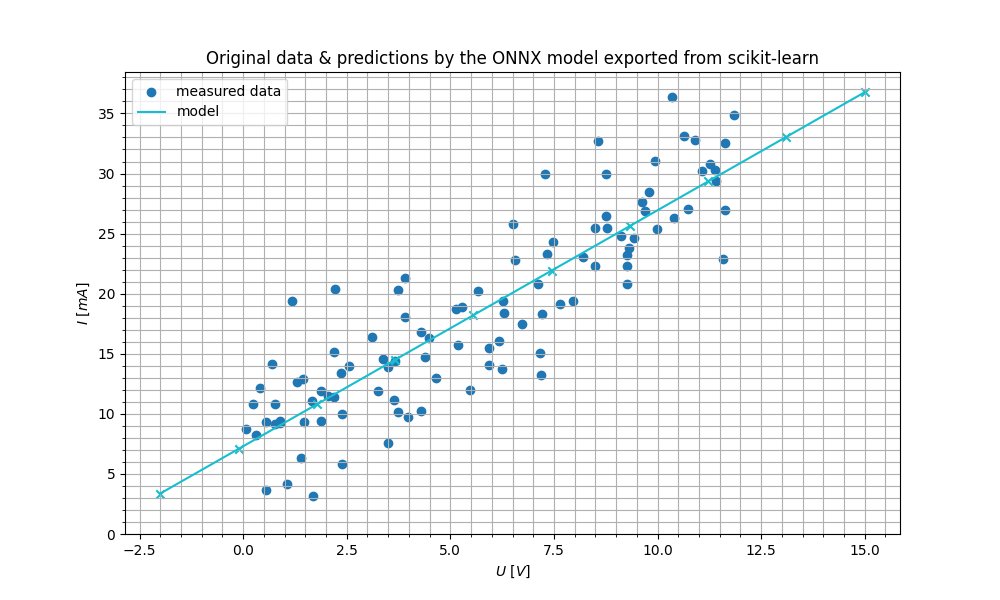

In [11]:
import onnxruntime as ort

# Load the ONNX model
# Specify the path to the ONNX model file
onnx_model_path = "sklearn_regression.onnx"

# Create an InferenceSession to load the model
session = ort.InferenceSession(onnx_model_path)

# Example input data (make sure it matches the input shape expected by the model)
# Let us create some new input data. Here, we create a NumPy array with shape
# (10, 1) representing 10 samples with 1 feature (voltage) each.
# We sample 10 equidistant points between 0 and 15.
U_new = np.linspace(start=-2, stop=15, num=10, dtype=np.float32).reshape(-1, 1)

# Get the name of the input node
# The model may have multiple inputs, but we usually need the first one
input_name = session.get_inputs()[0].name

# Get the name of the output node
# Similarly, the model may have multiple outputs, but we usually need the first one
output_name = session.get_outputs()[0].name

# Run inference
# The run method takes a list of output node names and a dictionary mapping input node names to input data
# It returns a list of outputs corresponding to the output node names provided
ii_sklearn_onnx = session.run([output_name], {input_name: U_new})

# Plot the predictions
# The predictions are returned as a list of NumPy arrays, so we print the first (and only) element
mu.plot_measurement_data(
    uu,
    ii,
    ii_sklearn_onnx[0].flatten(),
    xx_pred=U_new.flatten(),
    title="Original data & predictions by the ONNX model exported from scikit-learn",
)

#### Fragen/Zusatzaufgaben (Optional)
1. Was passiert in obigem Beispiel wenn wir in der Zeile
   `U_new = np.linspace(start=0, stop=15, num=10, dtype=np.float32).reshape(-1,1) `
   das Argument `dtype=np.float32` ersetzen durch `dtype=np.float64`?
2. Wie genau stimmen die Prognosen des ONNX-Modells (von scikit-learn exportiert) mit denen des originalen Modells (ursprüngliche scikit-learn Modell) überein? Evaluiere hierzu beide Modelle auf jeweils denselben Input-Daten (entweder die bereits vorhanden Daten oder beispielsweise neu erzeugte (zufällige) Daten für die Spannung $U [V]$.)


## Variante 2: Training eines PyTorch Modells und Export nach ONNX
- TODO: Kurze Beschreibung von PyTorch

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim


# Define the model
class SimpleLinearModel(nn.Module):
    """A simple linear regression model.

    This model consists of a single linear layer with one input and one output. It is used
    for simple linear regression tasks where the relationship between the input and output
    is assumed to be linear.
    """

    def __init__(self):
        """Initialize the SimpleLinearModel.

        This model consists of a single linear layer with one input and one output.
        """
        super().__init__()
        # Define a single linear layer with 1 input and 1 output
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        """Perform a forward pass through the model.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, 1).

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, 1) after applying the linear layer.
        """
        # Forward pass: compute the output of the linear layer
        return self.linear(x)

In [13]:
# Instantiate the model
pytorch_regressor = SimpleLinearModel()
print(pytorch_regressor)  # Print the model architecture

SimpleLinearModel(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)


In [14]:
# Lets get our original dataset again:
uu, ii = df.to_numpy(dtype=np.float32).T

# Define the loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.SGD(
    pytorch_regressor.parameters(), lr=0.01
)  # Stochastic Gradient Descent optimizer with learning rate 0.01


# Convert data to PyTorch tensors
u_tensor = torch.from_numpy(uu.reshape(-1, 1))
i_tensor = torch.from_numpy(ii.reshape(-1, 1))

# Train the model
num_epochs = 50  # Number of epochs to train

for epoch in range(num_epochs):
    # In practice this is usually not done, but train on the overall dataset
    # here.

    # Zero the parameter gradients
    optimizer.zero_grad()

    # Forward pass: compute the model output for the batch
    outputs = pytorch_regressor(u_tensor)

    # Compute the loss
    loss = criterion(outputs, i_tensor)

    # Backward pass: compute the gradients
    loss.backward()

    # Update the model parameters
    optimizer.step()

    # Print the loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(
            f"Epoch [{epoch + 1}/{num_epochs}], MSE Loss: {loss.item():.4f}, SSE Loss: {loss.item() * i_tensor.shape[0]:.2f}"
        )

Epoch [10/50], MSE Loss: 28.2997, SSE Loss: 2829.97
Epoch [20/50], MSE Loss: 26.8483, SSE Loss: 2684.83
Epoch [30/50], MSE Loss: 25.5507, SSE Loss: 2555.07
Epoch [40/50], MSE Loss: 24.3906, SSE Loss: 2439.06
Epoch [50/50], MSE Loss: 23.3535, SSE Loss: 2335.35


In [15]:
# Accessing the trained parameters
print("Trained parameters (state_dict):")
for param_tensor in pytorch_regressor.state_dict():
    print(f"{param_tensor}: {pytorch_regressor.state_dict()[param_tensor].numpy()}")

# Extract specific parameters
weights = pytorch_regressor.linear.weight.data.numpy()
bias = pytorch_regressor.linear.bias.data.numpy()

print("\nExtracted parameters:")
print(f"Weights: {weights}")
print(f"Bias: {bias}")

Trained parameters (state_dict):
linear.weight: [[2.6697617]]
linear.bias: [1.7778766]

Extracted parameters:
Weights: [[2.6697617]]
Bias: [1.7778766]


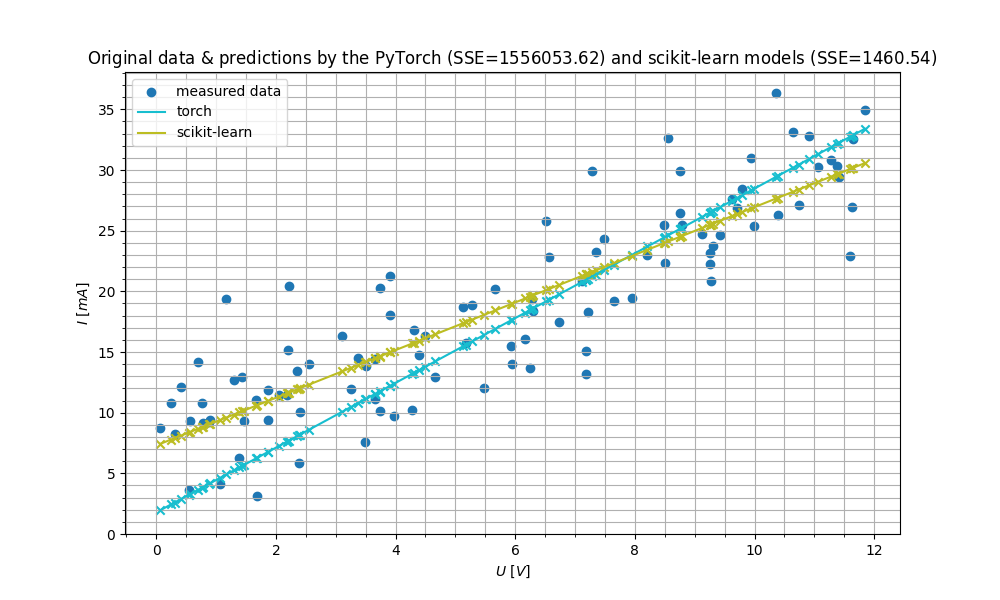

In [16]:
# Get the model's predictions and plot
with torch.no_grad():  # Disable gradient computation for inference
    ii_pytorch = pytorch_regressor(
        u_tensor
    ).numpy()  # Get the predictions and convert to NumPy array

sse_torch = mu.sse(ii, ii_pytorch)
sse_scikit = mu.sse(ii, ii_scikit)
mu.plot_measurement_data(
    uu.flatten(),
    ii.flatten(),
    {"torch": ii_pytorch, "scikit-learn": ii_scikit},
    title=f"Original data & predictions by the PyTorch (SSE=${sse_torch:.2f}$) and scikit-learn models (SSE=${sse_scikit:.2f}$)",
)

### Fragen/Zusatzaufgaben (Optional):
1. Woran könnte es liegen, dass die Geraden (Prognosen) für "pytorch" und "scikit-learn" nicht übereinstimmen?
2. Wie könnte man das ausgemachte Problem aus 1. beheben?

### Export des PyTorch Modells nach ONNX

In [17]:
# Export the model to ONNX
# Create a dummy input tensor with the same shape as the model input
dummy_input = torch.randn(1, 1)

# Specify the path where the ONNX file will be saved
onnx_file_path = "pytorch_regression.onnx"

# Export the model to ONNX format
torch.onnx.export(
    pytorch_regressor,  # The trained PyTorch model to be exported
    dummy_input,  # A dummy input tensor to trace the model
    onnx_file_path,  # The path where the ONNX file will be saved
    input_names=["input"],  # A list of input names for the ONNX model
    output_names=["output"],  # A list of output names for the ONNX model
    dynamic_axes={
        "input": {0: "batch_size"},
        "output": {0: "batch_size"},
    },  # Specify which axes are dynamic (e.g., batch size)
)

# Print a confirmation message
print(f"Model has been converted to ONNX and saved at {onnx_file_path}")

Model has been converted to ONNX and saved at pytorch_regression.onnx


#### Visualisierung des PyTorch-exportierten ONNX-Graphen mit Netron

In [18]:
from techdays25 import onnx_utils

onnx_utils.netron_visualize("pytorch_regression.onnx")

<IPython.core.display.Javascript object>

#### Fragen/Zusatzaufgaben (Optional)
1. Inwieweit unterscheidet sich das obige ONNX-Modell von dem ONNX-Modell das wir aus scikit-learn exportiert haben?
2. Was verbirgt sich hinter der Operation im obigen Graphen? Hinweis: In den "Node Properties" kann beispielsweise für das Feld "type" ein Hilfefenster angezeigt werden.

## Variante 3 (Optional): Training eines Keras/Tensorflow Modells und Export nach ONNX

## Variante 4 (Optional): Wir "trainieren" das Modell selbst

In [ ]:
import sympy

# Lets get our original dataset again:
uu, ii = df.to_numpy().T

U = np.stack([uu, np.ones(len(uu))]).T
sympy.Matrix(U[:5])